In [58]:
import math
import random
import numpy as np
import scipy
from matplotlib import pyplot as plt
from math import pi


def normalize(vec):
  return vec / np.linalg.norm(vec)


def random_point_on_a_sphere(n):
  return normalize(np.random.normal(0, 1, n))


def gs(vecs):
  proj = lambda of, on: np.dot(of, on) / np.dot(on, on) * on
  e = []

  for vec in vecs:
    e.append(normalize(vec - np.sum([proj(vec, ej) for ej in e], axis=0)))
  
  return e


def build_onb(vec, eps=1e-6):
  n = len(vec)
  E = [np.array([int(i == j) for j in range(n)]) for i in range(n)]
  E.pop(next(i for i, x in enumerate(vec) if not abs(x) < eps))
  return gs([vec, *E])


def random_elipsoid(n, S, sigma_dist, p):
  sigma = np.diag(sigma_dist(n) ** 2)

  e = np.column_stack(build_onb(random_point_on_a_sphere(n)))
  c = math.sqrt(2 * scipy.special.gammaincinv(n / 2, p))
  l = c * sigma ** 0.5

  X = np.random.multivariate_normal(np.zeros(n), e @ sigma @ e.transpose(), S)

  # print("p = {} (expected {})".format(
  #   sum([1 for x in X if np.sum(np.array(np.linalg.inv(e @ l) @ np.matrix([x]).transpose())[:, 0] ** 2) <= 1]) / len(X),
  #   p
  # ))

  return X, e, l, np.zeros(n)

In [59]:
def gd_in_bounds(func, grad, initial, check_bound, fix_bound, rate, record_path, eps=1e-3):
  path = [initial]

  for _ in range(1000):
    current = path[-1]

    # Если мы близки къ нулю, включаемъ болѣе точный режимъ
    r = rate(current)
    # print("Current rate: {}".format(r))
    next = current - r * grad(current)

    # Возвращеніе точки въ область, если нарушены границы.
    if not check_bound(next):
      next = fix_bound(next)
    
    path.append(next)

    # Условіе останова
    if abs(func(next)) < eps or abs(func(next) - func(current)) < eps:
      break

  # Возвращаем найденный оптимум или путь после останова
  return np.array(path) if record_path else path[-1]

path length = 9
t = 0.16226165119978955


/var/folders/h8/kb57sw8j05n3806kkhtfghdm0000gn/T/ipykernel_41585/299989976.py:20: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(xm, ym, zm, cmap='PuBu_r', shading='auto')


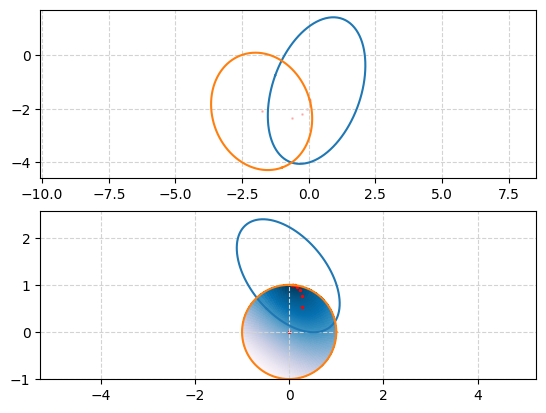

In [60]:
points_cnt = 100

def diag_inv(mat):
  return np.diag(np.ones(mat.shape[0]) / mat.diagonal())

def columnize(c, columns_size=points_cnt):
  return np.column_stack([c] * columns_size)

def color_ellipse(VD, c, func=lambda x, y: (x ** 2 + y ** 2) ** 0.5):
    r, theta = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 2 * pi, 100))
    xm, ym, zm = ([[0 for _ in range(len(r[i]))] for i in range(len(r))] for _ in range(3))
    for i in range(len(r)):
      for j in range(len(r[i])):
        xy = VD @ (r[i][j] * np.array([math.cos(theta[i][j]), math.sin(theta[i][j])])) + c
        x, y = xy
        xm[i][j] = x
        ym[i][j] = y
        zm[i][j] = func(x, y)
    xm, ym, zm = np.array(xm), np.array(ym), np.array(zm)
    plt.pcolor(xm, ym, zm, cmap='PuBu_r', shading='auto')


def draw_ellipses(ellipses):
  assert len(ellipses) == 2

  V1, D1, c1 = ellipses[0]
  V2, D2, c2 = ellipses[1]

  for i, ellipse in enumerate(ellipses):
    V, D, c = ellipse

    fi = np.linspace(0, 2 * pi, points_cnt)
    circle = np.array([np.cos(fi), np.sin(fi)])

    x1 = V @ D @ circle + columnize(c)
    x2 = diag_inv(D1) @ V1.transpose() @ (x1 - columnize(c1))
    c_new = diag_inv(D1) @ V1.transpose() @ (c2 - c1)
    VD_new = diag_inv(D1) @ V1.transpose() @ V2 @ D2
    x3 = np.linalg.inv(VD_new) @ (x2 - columnize(c_new))

    if i == 1:
      anti_ellipsoid = lambda x: (VD_new @ x + np.column_stack(c_new))[0]
      func = lambda x: np.linalg.norm(anti_ellipsoid(x))
      grad = lambda x: (VD_new.transpose() @ normalize(anti_ellipsoid(x)))
      check_bounds = lambda x: np.linalg.norm(x) <= 1
      fix_bound = lambda x: normalize(x)
      rate = lambda x: func(x) / np.linalg.norm(VD_new) ** 2
      # rate = lambda x: 1e-2
      path_x3 = gd_in_bounds(func, grad, np.zeros_like(c_new), check_bounds, fix_bound, rate, True)
      path_x3 = path_x3.transpose()

      path_x2 = VD_new @ path_x3 + columnize(c_new, path_x3.shape[1])
      path_x1 = V1 @ D1 @ path_x2 + columnize(c1, path_x2.shape[1])

      t = np.linalg.norm(path_x2.transpose()[-1])
      print("path length = {}".format(len(path_x3[0])))
      print("t = {}".format(t))

    plt.subplot(2, 1, 1)
    plt.plot(*x1)

    if i == 1:
      plt.scatter(*path_x1, s=1, c='red', alpha=0.2)

    plt.subplot(2, 1, 2)
    plt.plot(*x3)

    if i == 1:
      func = lambda x, y: np.linalg.norm(VD_new @ np.array([x, y]) + np.column_stack(c_new))
      color_ellipse(np.diag(np.ones_like(c_new)), np.zeros_like(c_new), func)
      plt.scatter(*path_x3, s=2, c='red')

  for i in range(2):
    plt.subplot(2, 1, i + 1)
    plt.axis('equal')
    plt.grid(color='lightgray', linestyle='--')

  plt.show()

ellipses = [(
  *random_elipsoid(2, 0, lambda n : np.random.uniform(0.5, 1.5, n), p=0.85)[1:3],
  random.uniform(1, 5) * random_point_on_a_sphere(2)
) for _ in range(2)]

draw_ellipses(ellipses)
